In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import re
import torch

In [ ]:
def preprocess_text(text):

    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'&[a-zA-Z]+;', '', text)
    return text

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving drugsComTest_updated.csv to drugsComTest_updated.csv


In [ ]:
import pandas as pd


df = pd.read_csv('drugsComTest_updated.csv')

df_reduced = df.sample(frac=0.2, random_state=42)

df_reduced = df_reduced[['review', 'rating']]

df_reduced['label'] = df_reduced['rating'].apply(lambda x: 1 if x >= 4 else 0)

df_reduced.head()


,review,rating,label
48164,"""Topamax worked pretty well for my daily heada...",8,1
20005,"""My young son was presciribed this for severe ...",1,0
25314,"""I was on Latuda, for 23 days for my post trau...",2,0
36722,"""Im in my 30 5&#039;6 and my starting weight w...",9,1
4243,"""I am a 34 year old teacher from East London. ...",10,1


In [ ]:

dataset = Dataset.from_pandas(df_reduced)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def tokenize_function(examples):
  return tokenizer(examples['review'], padding="max_length", truncation=True)

In [ ]:
tokenized_dataset = dataset.map(tokenize_function,batched=True)

Map:   0%|          | 0/10694 [00:00<?, ? examples/s]

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [ ]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [ ]:
print(train_dataset[0])

{'review': '"was diagnosed in 2006, but most likely contracted it back in the late mid 70s...I started on Harvoni in November 2015, finished 1/2016..I had not one side effect what so ever.  My last viral count was zero!!! I am not on any other medications but I do take a super b complex vitamin every day..taking this medicine was a piece of cake !!\r\nThank you to whomever came up with this medicine."', 'rating': 10, 'label': 1, '__index_level_0__': 31747, 'input_ids': [101, 1000, 2001, 11441, 1999, 2294, 1010, 2021, 2087, 3497, 11016, 2009, 2067, 1999, 1996, 2397, 3054, 17549, 1012, 1012, 1012, 1045, 2318, 2006, 5292, 2099, 17789, 2072, 1999, 2281, 2325, 1010, 2736, 1015, 1013, 2355, 1012, 1012, 1045, 2018, 2025, 2028, 2217, 3466, 2054, 2061, 2412, 1012, 2026, 2197, 13434, 4175, 2001, 5717, 999, 999, 999, 1045, 2572, 2025, 2006, 2151, 2060, 20992, 2021, 1045, 2079, 2202, 1037, 3565, 1038, 3375, 17663, 2296, 2154, 1012, 1012, 2635, 2023, 4200, 2001, 1037, 3538, 1997, 9850, 999, 999, 40

In [ ]:
def compute_metrics(p):
  predictions, labels = p
  preds = predictions.argmax(axis=-1)
  return{"accuracy": accuracy_score(labels,preds)}

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: varshanistala (varshanistala-ibm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.238200,0.304930,0.878915
2,0.214700,0.368554,0.889668


TrainOutput(global_step=2140, training_loss=0.3254973148352632, metrics={'train_runtime': 1898.484, 'train_samples_per_second': 9.012, 'train_steps_per_second': 1.127, 'total_flos': 4501830157209600.0, 'train_loss': 0.3254973148352632, 'epoch': 2.0})

In [ ]:
results = trainer.evaluate()
print(f"Evaluation results: {results}")

Evaluation results: {'eval_loss': 0.3049298822879791, 'eval_accuracy': 0.8789153810191679, 'eval_runtime': 64.6035, 'eval_samples_per_second': 33.11, 'eval_steps_per_second': 4.148, 'epoch': 2.0}


In [ ]:

def predict_sentiment(review_text):
    review_text = preprocess_text(review_text)

    inputs = tokenizer(review_text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

        logits = outputs.logits

        probabilities = torch.nn.functional.softmax(logits, dim=-1)

        predicted_class = torch.argmax(probabilities, dim=-1).item()

    return "Good" if predicted_class == 1 else "Bad"

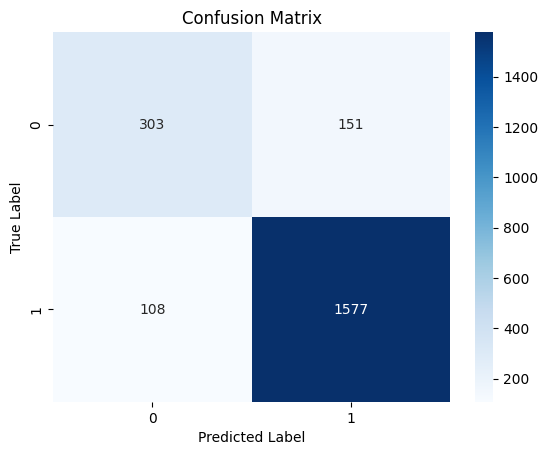

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_dataset['label']
y_pred = trainer.predict(test_dataset).predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


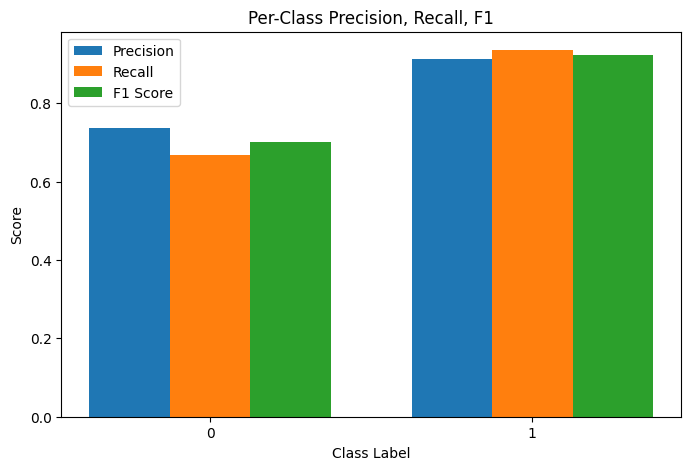

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
labels = list(range(len(prec)))

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Class Label")
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.xticks(x, labels)
plt.legend()
plt.show()


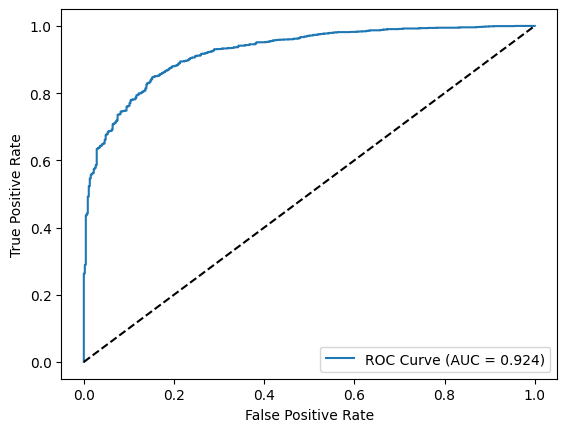

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.special import softmax
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_true = predictions.label_ids

probs = softmax(logits, axis=1)[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



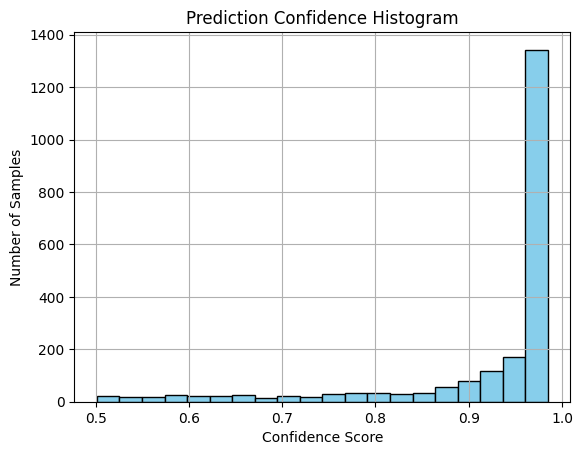

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

confidence = probs if probs.ndim == 1 else np.max(probs, axis=1)

plt.hist(confidence, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

logits = predictions.predictions
y_true = test_dataset['label']
y_pred = np.argmax(logits, axis=1)

probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)


print(" Accuracy:", accuracy_score(y_true, y_pred))
print(" Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print(" Classification Report:\n", classification_report(y_true, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


print(" Log Loss:", log_loss(y_true, probs))
print(" Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
print(" Matthews Corr Coef:", matthews_corrcoef(y_true, y_pred))

if probs.shape[1] == 2:
    y_probs = probs[:, 1]
    print(" ROC AUC (binary):", roc_auc_score(y_true, y_probs))
else:
    auc_score = roc_auc_score(y_true, probs, multi_class='ovr', average='macro')
    print(" ROC AUC (macro):", auc_score)



 Accuracy: 0.8789153810191679
 Macro F1 Score: 0.8123458588294671
 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70       454
           1       0.91      0.94      0.92      1685

    accuracy                           0.88      2139
   macro avg       0.82      0.80      0.81      2139
weighted avg       0.88      0.88      0.88      2139

 Confusion Matrix:
 [[ 303  151]
 [ 108 1577]]
 Log Loss: 0.30492987919953934
 Cohen's Kappa: 0.6249266272501823
 Matthews Corr Coef: 0.6261417892222321
 ROC AUC (binary): 0.9235199152930104


In [ ]:
user_input = input("Enter a drug review: ")
sentiment = predict_sentiment(user_input)

print(f"Predicted Sentiment: {sentiment}")

Enter a drug review: Started taking Paracetamol for fever and headache. Within an hour, my symptoms improved a lot. No side effects and works quickly. Highly recommend for quick relief.
Predicted Sentiment: Good


In [ ]:
user_input = input("Enter a drug review: ")
sentiment = predict_sentiment(user_input)

print(f"Predicted Sentiment: {sentiment}")

Enter a drug review: I took this medication for stomach cramps but it made me feel worse. Felt nauseous and dizzy after just one dose. Wouldn’t take it again.
Predicted Sentiment: Bad
